# RMIA (Relative Membership Inference Attack) Implementation

This notebook implements the RMIA attack from the paper 'Low-Cost High-Power Membership Inference Attacks'.

## Import Required Libraries
- **numpy**: For numerical operations and averaging
- **torch**: PyTorch deep learning framework
- **torchvision**: Pre-trained models and datasets (CIFAR-10)
- **sklearn**: For ROC curve and AUC metrics
- **matplotlib**: For visualizing results

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Training Function

This function trains a ResNet-18 model on CIFAR-10 dataset.

**Steps:**
1. Initialize ResNet-18 architecture with 10 output classes
2. Define Cross-Entropy loss function for classification
3. Use Adam optimizer with learning rate of 0.001
4. Train for specified number of epochs (default: 5)
5. For each batch: compute loss, backpropagate, update weights

**Note:** We use only 5 epochs (vs. 100 in the paper) for faster training.

In [6]:
#train the provided model
def train_model(dataloader, epochs=5):
    model = resnet18(num_classes=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

## RMIA Score Calculation (Multi-Reference)

This is the core RMIA attack function using multiple reference models.

**Parameters:**
- `tar_model`: Target (victim) model we're attacking
- `ref_models`: List of reference models trained on different data
- `known_img`: Test sample image
- `known_label`: True label of test sample
- `population_subset`: Population samples for likelihood ratio comparison
- `gamma`: Threshold parameter (default: 1.0)
- `a`: Offline approximation parameter (default: 0.3)

**Algorithm:**
1. Compute target model probability for test sample x
2. Average reference model probabilities for x (Pr(x)_OUT)
3. Apply offline approximation formula to estimate Pr(x)
4. Calculate likelihood ratio for x
5. Compare x's ratio against population samples (z)
6. Count how many population samples have lower ratios
7. Return normalized score (higher = more likely member)

In [7]:
#calculate the rmia score providing multiple reference models
def get_rmia_score_multi(tar_model, ref_models, known_img, known_label, population_subset, gamma=1.0, a=0.3):
    tar_model.eval()
    for rm in ref_models: rm.eval()

    with torch.no_grad():
        prob_x_target = torch.softmax(tar_model(known_img.unsqueeze(0)), dim=1)[0, known_label].item()

        # Average predictions across all reference models to get a more stable Pr(x)OUT
        all_ref_probs_x = [torch.softmax(rm(known_img.unsqueeze(0)), dim=1)[0, known_label].item() for rm in ref_models]
        prob_x_out = np.mean(all_ref_probs_x)

        # Offline scaling approximation
        # we add a really low number "1e-10" that is not changing the result on the divider to avoid division with 0
        pr_x = 0.5 * ((1 + a) * prob_x_out + (1 - a))
        ratio_x = prob_x_target / (pr_x + 1e-10)

        count_dominated = 0
        for z_img, z_label in population_subset:
            prob_z_target = torch.softmax(tar_model(z_img.unsqueeze(0)), dim=1)[0, z_label].item()

            # Average predictions for population samples [cite: 559]
            all_ref_probs_z = [torch.softmax(rm(z_img.unsqueeze(0)), dim=1)[0, z_label].item() for rm in ref_models]
            prob_z_out = np.mean(all_ref_probs_z)

            ratio_z = prob_z_target / (prob_z_out + 1e-10)

            if (ratio_x / (ratio_z + 1e-10)) > gamma:
                count_dominated += 1

    return count_dominated / len(population_subset)

## Data Preparation and Target Model Training

**Data Split:**
- Load CIFAR-10 dataset (50,000 training images)
- Split into:
  - 20,000 samples: Target model training (members)
  - 20,000 samples: Test set (non-members)
  - 10,000 samples: Population set (for RMIA baseline)

**Preprocessing:**
- Convert images to tensors
- Normalize with mean=0.5, std=0.5 for each RGB channel

**Target Model:**
- Train ResNet-18 on member data (20k samples)
- This is the 'victim' model we'll attack

In [8]:
# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Partitioning: 20k members, 20k non-members, 10k population
target_train, target_test, population_data, _ = torch.utils.data.random_split(
    full_trainset, [20000, 20000, 10000, 0]
)

print("\nLoading CIFAR-10...")
train_loader = DataLoader(target_train, batch_size=64, shuffle=True)

# Initialize and train target model
print("Training Target Model (Member data)...")
target_model = train_model(train_loader)



Loading CIFAR-10...
Training Target Model (Member data)...


In [9]:
#Train multiple reference models
num_ref_models = 8  # You can increase this (e.g., 4, 8, or 16)
ref_models = []
pop_indices = np.arange(len(population_data))

for i in range(num_ref_models):
    print(f"Training Reference Model {i+1}/{num_ref_models}...")

    # Each model is trained on a different random subset of population data
    # for better diversity, as suggested by the sampling methods in the paper
    np.random.shuffle(pop_indices)
    subset_indices = pop_indices[:len(pop_indices) // 2]
    ref_subset = Subset(population_data, subset_indices)
    ref_loader = DataLoader(ref_subset, batch_size=64, shuffle=True)

    ref_models.append(train_model(ref_loader))

Training Reference Model 1/8...
Training Reference Model 2/8...
Training Reference Model 3/8...
Training Reference Model 4/8...
Training Reference Model 5/8...
Training Reference Model 6/8...
Training Reference Model 7/8...
Training Reference Model 8/8...


In [13]:
#find score on 1 member of the train_data
img, lbl = target_train[0]

# Select baseline z-samples from population
z_samples = [population_data[i] for i in range(100)]

#calculate scores using different number of ref_models
score1ref = get_rmia_score_multi(target_model, ref_models[:1], img, lbl, z_samples)
score2ref = get_rmia_score_multi(target_model, ref_models[:2], img, lbl, z_samples)
score4ref = get_rmia_score_multi(target_model, ref_models[:4], img, lbl, z_samples)
score8ref = get_rmia_score_multi(target_model, ref_models[:8], img, lbl, z_samples)
print(f"RMIA Membership Scores (closer to 1.0 is more likely a member)")
print(f"RMIA Membership Score for 1 ref_model: {score1ref:.4f}")
print(f"RMIA Membership Score for 2 ref_models: {score2ref:.4f}")
print(f"RMIA Membership Score for 4 ref_models: {score4ref:.4f}")
print(f"RMIA Membership Score for 8 ref_models: {score8ref:.4f}")

RMIA Membership Scores (closer to 1.0 is more likely a member)
RMIA Membership Score for 1 ref_model: 0.3000
RMIA Membership Score for 2 ref_models: 0.3700
RMIA Membership Score for 4 ref_models: 0.3300
RMIA Membership Score for 8 ref_models: 0.3400


In [16]:
all_scores, all_labels = [], []

# Test attack on 100 members and 100 non-members on the 8 ref models trained
for i in range(100):
    # Member test
    img, lbl = target_train[i]
    all_scores.append(get_rmia_score_multi(target_model, ref_models, img, lbl, z_samples))
    all_labels.append(1)
    # Non-member test
    img, lbl = target_test[i]
    all_scores.append(get_rmia_score_multi(target_model, ref_models, img, lbl, z_samples))
    all_labels.append(0)

Attack AUROC: 0.6647


Attack AUROC (AUC): 0.6647


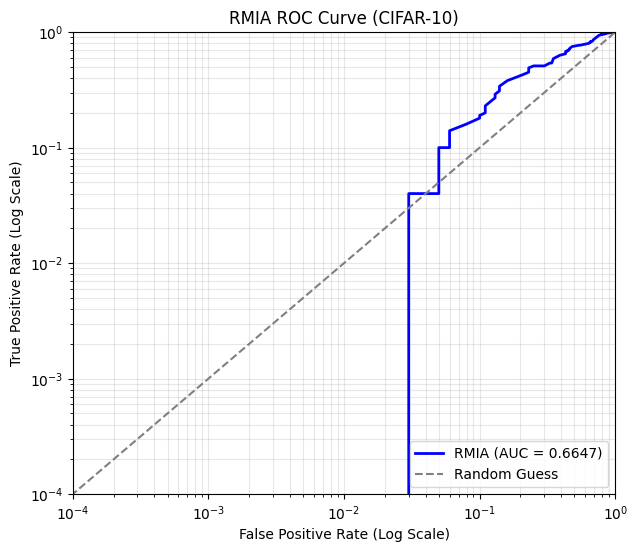

In [23]:
# AUC calculation
fpr, tpr, _ = roc_curve(all_labels, all_scores)
print(f"Attack AUROC (AUC): {auc(fpr, tpr):.4f}")

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))

# Plot the Attack Curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'RMIA (AUC = {roc_auc:.4f})')

# Plot the Random Guess line (diagonal)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

# Formatting for "Log Scale" (Crucial for RMIA evaluation)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-4, 1.0]) # Focus on low FPR regions
plt.ylim([1e-4, 1.0])

plt.xlabel('False Positive Rate (Log Scale)')
plt.ylabel('True Positive Rate (Log Scale)')
plt.title('RMIA ROC Curve (CIFAR-10)')
plt.legend(loc="lower right")
plt.grid(True, which="both", ls="-", alpha=0.3)

plt.show()

With the value of AUC = 0.6647 for 8 reference models used in our experiment we can validate that the attack is working. The paper gives 68.64±0.43 with 1 reference model, 70.13±0.37 for 2 and 71.02±0.37 for 4. Our result is lower probably due to the use of different model (we used the resnet18), but also due to low number of epochs (only 5 in our case compared to 100 for the paper) and low number of evaluation images (200 in our case compared to thousands for the paper).

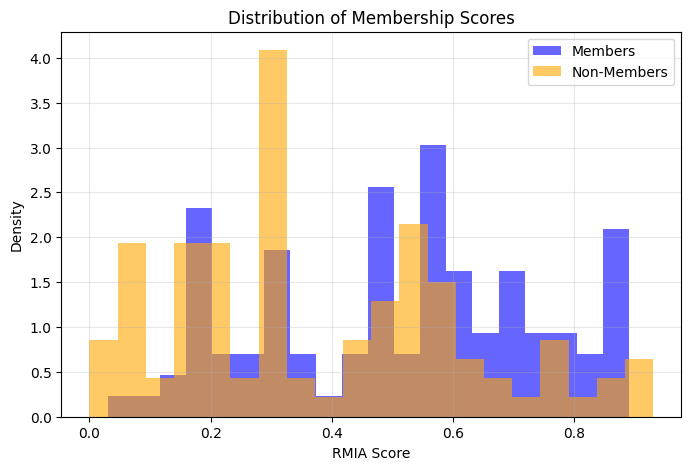

In [24]:
# Separate scores back into two groups for plotting
member_scores_only = [score for score, label in zip(all_scores, all_labels) if label == 1]
non_member_scores_only = [score for score, label in zip(all_scores, all_labels) if label == 0]

plt.figure(figsize=(8, 5))

# Plot histograms with transparency
plt.hist(member_scores_only, bins=20, alpha=0.6, color='blue', label='Members', density=True)
plt.hist(non_member_scores_only, bins=20, alpha=0.6, color='orange', label='Non-Members', density=True)

plt.xlabel('RMIA Score')
plt.ylabel('Density')
plt.title('Distribution of Membership Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

From the above histogram we understand that most of the non-members are achieving a lower score than the members, as the non-members scores are gathered on the left side of the graph while the member scores are gathered on the right side of the graph